### **Version 1** -- Submit ID: 271526

In [ ]:
# submit id === 271526
import pandas as pd
import json
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import xgboost as xgb

submissions = pd.read_csv('annonimized.csv')
scores = pd.read_csv('th-public.csv')

scores['TH'] = pd.to_numeric(scores['TH'], errors='coerce')
print(f"Số giá trị NaN trong TH sau khi làm sạch: {scores['TH'].isna().sum()}")
scores = scores.dropna(subset=['TH'])

def parse_judgement(judgement_str):
    try:
        judgement_str = judgement_str.replace('\xa0', '').replace('""', '"')
        judgement = json.loads(judgement_str)
        wrong_count = judgement.get('verdicts', {}).get('WRONG', 0)
        times = judgement.get('times', [])
        mems = judgement.get('mems', [])
        return (wrong_count,
                np.mean(times) if times and all(isinstance(t, (int, float)) for t in times) else 0,
                np.mean(mems) if mems and all(isinstance(m, (int, float)) for m in mems) else 0)
    except:
        return 0, 0, 0

submissions[['wrong_count', 'avg_time', 'avg_mem']] = submissions['judgement'].apply(parse_judgement).apply(pd.Series)

def extract_features(group):
    features = {}
    features['num_submissions'] = len(group)
    features['num_final_submissions'] = group['is_final'].sum()
    features['avg_pre_score'] = group['pre_score'].mean()
    features['max_pre_score'] = group[group['is_final'] == 1]['pre_score'].max() if group['is_final'].sum() > 0 else 0
    features['success_rate'] = (group['pre_score'] == 10000).mean()
    features['compile_error_rate'] = (group['status'] == 'Compilation Error').mean()
    features['avg_coefficient'] = group['coefficient'].mean()
    features['num_problems'] = group["concat('it001',`problem_id`)"].nunique()
    features['num_assignments'] = group["concat('it001',`assignment_id`)"].nunique()
    features['avg_wrong_count'] = group['wrong_count'].mean()
    features['avg_time'] = group['avg_time'].mean()
    features['avg_mem'] = group['avg_mem'].mean()
    return pd.Series(features)

features_df = submissions.groupby("concat('it001', username)").apply(extract_features, include_groups=False).reset_index()

data = features_df.merge(scores, left_on="concat('it001', username)", right_on='hash', how='left')

train_data = data[data['TH'].notna()]
test_data = data[data['TH'].isna()]

X = train_data.drop(["concat('it001', username)", 'hash', 'TH'], axis=1)
y = train_data['TH']
X_predict = test_data.drop(["concat('it001', username)", 'hash', 'TH'], axis=1)

for col in X.columns:
    X[col] = pd.to_numeric(X[col], errors='coerce').fillna(0)
for col in X_predict.columns:
    X_predict[col] = pd.to_numeric(X_predict[col], errors='coerce').fillna(0)


X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(y_train.dtype)
print(y_train.head())
print(y_train[y_train.astype(str).str.contains('\xa0', na=False)])

model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_val)
print(f"R² Score: {r2_score(y_val, y_pred)}")

predictions = model.predict(X_predict)

submission = pd.DataFrame({'hash': test_data["concat('it001', username)"], 'TH': predictions})
all_usernames = pd.DataFrame({'hash': submissions["concat('it001', username)"].unique()})
submission = all_usernames.merge(submission, on='hash', how='left').fillna(0)
submission.to_csv('submission.csv', index=False)

Số giá trị NaN trong TH sau khi làm sạch: 8
                  concat('it001', username)    TH
0  00b6dd4fc7eb817e03708c532016ef30ce564a61   5.0
1  00bef8afee8f3c595d535c9c03c490cac1a4f021   8.5
2  01122b3ef7e59b84189e65985305f575d6bdf83c   7.0
4  013de369c439ab0ead8aa7da64423aa395a8be39  10.0
5  014c59c6433fd764a0b08de6ffeb757eaf60aa73   6.0
float64
0
float64
622    8.5
141    5.0
47     9.5
74     8.0
617    8.5
Name: TH, dtype: float64
Series([], Name: TH, dtype: float64)
R² Score: 0.37829928085064535


**Kết quả**
* Điểm R2 khi train: 0.378
* Điểm R2 khi test trên hệ thống wecode: 0.26

==> Có sự overfit và các feature chưa đủ mạnh (chưa đủ để phản ánh sự ảnh hưởng đến điểm thực hành)

==> Tiến hành visualize để phân tích

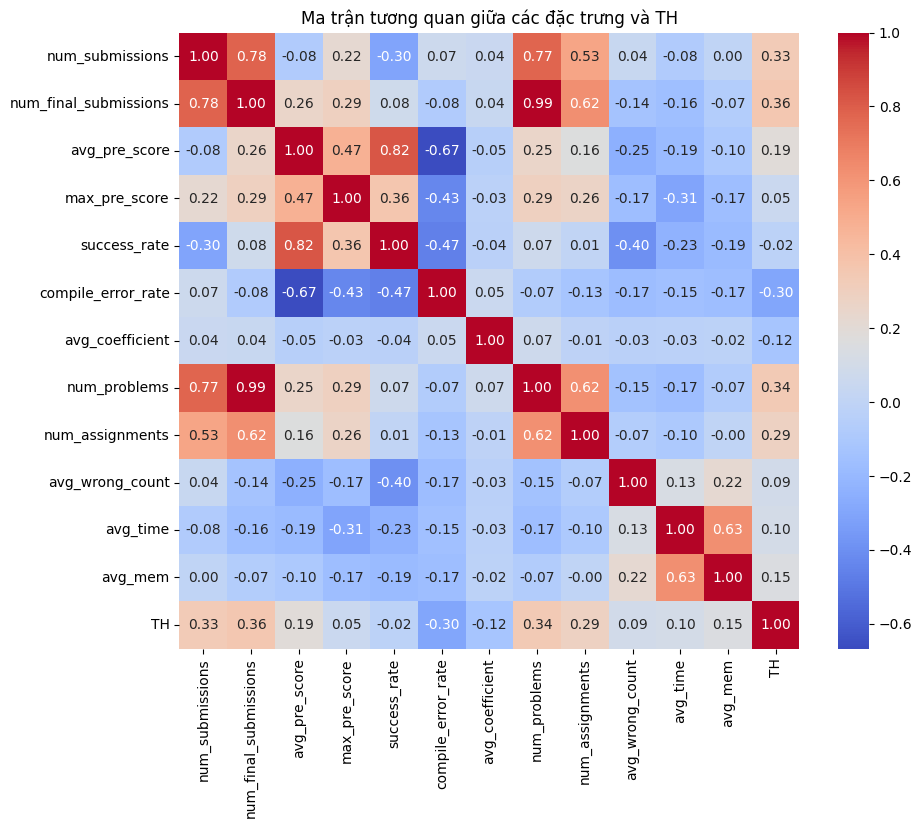

TH                       1.000000
num_final_submissions    0.358261
num_problems             0.340706
num_submissions          0.331316
num_assignments          0.287877
avg_pre_score            0.187059
avg_mem                  0.152200
avg_time                 0.102188
avg_wrong_count          0.092408
max_pre_score            0.049618
success_rate            -0.018545
avg_coefficient         -0.124541
compile_error_rate      -0.297053
Name: TH, dtype: float64


In [ ]:
# heatmap
correlation_matrix = train_data.drop(["concat('it001', username)", 'hash'], axis=1).corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Ma trận tương quan giữa các đặc trưng và TH')
plt.show()

print(correlation_matrix['TH'].sort_values(ascending=False))

### **Version 2** -- Submit ID: 271581

Trong version nộp bài này, có 2 cải tiến:
* Nhận thấy cột ceated_at có thể cung cấp thông tin về thời điểm nộp bài (các bạn nộp sớm thường chăm chỉ hơn -> điểm cao hơn)
* Thêm một số đặc trưng mới bao gồm:
  * Thêm avg_submission_day như ý trên
  * Có thể thêm min_submission_day (ngày nộp sớm nhất) hoặc submission_time_range (khoảng cách giữa nộp sớm nhất và muộn nhất).
  * thêm tỷ lệ bài nộp cuối cùng đúng (final_submission_success_rate).

In [ ]:
import pandas as pd
import json
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

submissions = pd.read_csv('annonimized.csv')
scores = pd.read_csv('th-public.csv')

scores['TH'] = pd.to_numeric(scores['TH'], errors='coerce')
print(f"Số giá trị NaN trong TH sau khi làm sạch: {scores['TH'].isna().sum()}")
scores = scores.dropna(subset=['TH'])

# add time
submissions['month'] = submissions['created_at'].str.split('-').str[0].astype(int)
submissions['day'] = submissions['created_at'].str.split('-').str[1].str.split(' ').str[0].astype(int)
submissions['submission_day'] = submissions['month'] * 30 + submissions['day']

def parse_judgement(judgement_str):
    try:
        judgement_str = judgement_str.replace('\xa0', '').replace('""', '"')
        judgement = json.loads(judgement_str)
        wrong_count = judgement.get('verdicts', {}).get('WRONG', 0)
        times = judgement.get('times', [])
        mems = judgement.get('mems', [])
        return (wrong_count,
                np.mean(times) if times and all(isinstance(t, (int, float)) for t in times) else 0,
                np.mean(mems) if mems and all(isinstance(m, (int, float)) for m in mems) else 0)
    except:
        return 0, 0, 0

submissions[['wrong_count', 'avg_time', 'avg_mem']] = submissions['judgement'].apply(parse_judgement).apply(pd.Series)

def extract_features(group):
    features = {}
    features['num_submissions'] = len(group)
    features['num_final_submissions'] = group['is_final'].sum()
    features['avg_pre_score'] = group['pre_score'].mean()
    features['max_pre_score'] = group[group['is_final'] == 1]['pre_score'].max() if group['is_final'].sum() > 0 else 0
    features['success_rate'] = (group['pre_score'] == 10000).mean()
    features['compile_error_rate'] = (group['status'] == 'Compilation Error').mean()
    features['avg_coefficient'] = group['coefficient'].mean()
    features['num_problems'] = group["concat('it001',`problem_id`)"].nunique()
    features['num_assignments'] = group["concat('it001',`assignment_id`)"].nunique()
    features['avg_wrong_count'] = group['wrong_count'].mean()
    features['avg_time'] = group['avg_time'].mean()
    features['avg_mem'] = group['avg_mem'].mean()
    features['avg_submission_day'] = group['submission_day'].mean()
    features['min_submission_day'] = group['submission_day'].min()
    features['submission_time_range'] = group['submission_day'].max() - group['submission_day'].min()
    features['final_submission_success_rate'] = group[group['is_final'] == 1]['pre_score'].eq(10000).mean()
    return pd.Series(features)

features_df = submissions.groupby("concat('it001', username)").apply(extract_features, include_groups=False).reset_index()

data = features_df.merge(scores, left_on="concat('it001', username)", right_on='hash', how='left')

train_data = data[data['TH'].notna()]
test_data = data[data['TH'].isna()]

X = train_data.drop(["concat('it001', username)", 'hash', 'TH'], axis=1)
y = train_data['TH']
X_predict = test_data.drop(["concat('it001', username)", 'hash', 'TH'], axis=1)

for col in X.columns:
    X[col] = pd.to_numeric(X[col], errors='coerce').fillna(0)
for col in X_predict.columns:
    X_predict[col] = pd.to_numeric(X_predict[col], errors='coerce').fillna(0)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_val)
print(f"R² Score: {r2_score(y_val, y_pred)}")

predictions = model.predict(X_predict)
submission = pd.DataFrame({'hash': test_data["concat('it001', username)"], 'TH': predictions})
all_usernames = pd.DataFrame({'hash': submissions["concat('it001', username)"].unique()})
submission = all_usernames.merge(submission, on='hash', how='left').fillna(0)
submission.to_csv('submission.csv', index=False)

Số giá trị NaN trong TH sau khi làm sạch: 8
R² Score: 0.25679546467426084


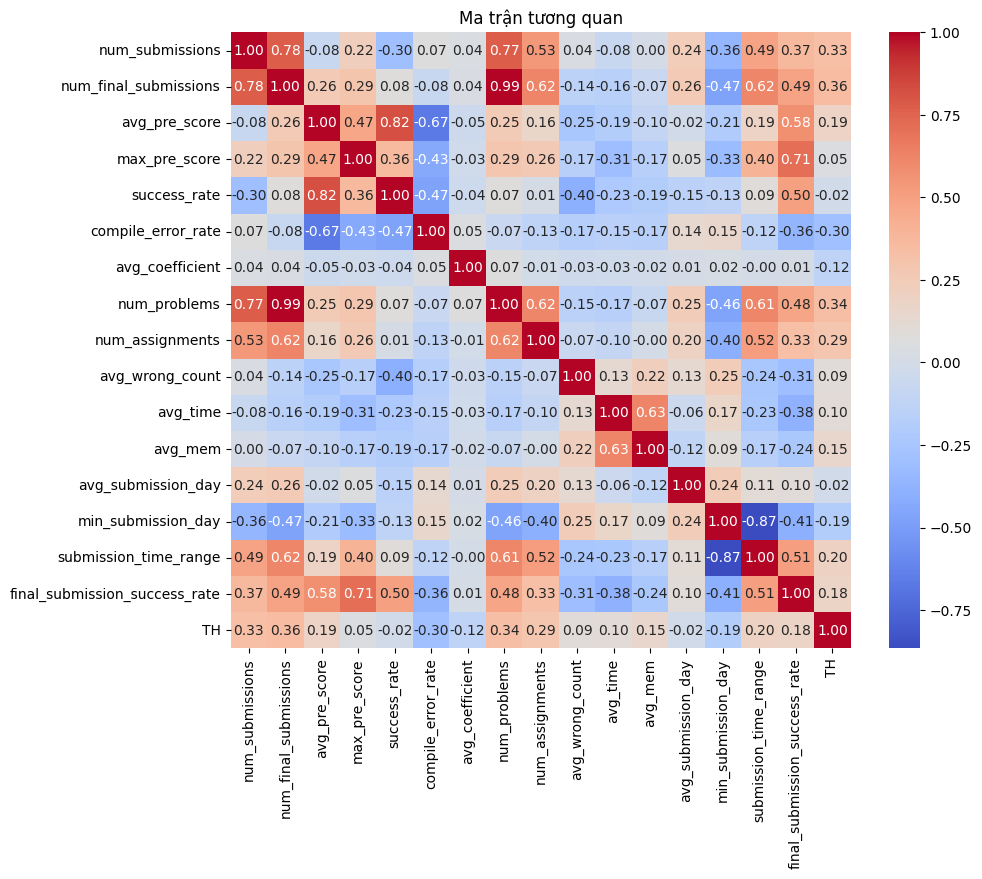

TH                               1.000000
num_final_submissions            0.358261
num_problems                     0.340706
num_submissions                  0.331316
num_assignments                  0.287877
submission_time_range            0.203919
avg_pre_score                    0.187059
final_submission_success_rate    0.182758
avg_mem                          0.152200
avg_time                         0.102188
avg_wrong_count                  0.092408
max_pre_score                    0.049618
avg_submission_day              -0.018194
success_rate                    -0.018545
avg_coefficient                 -0.124541
min_submission_day              -0.194253
compile_error_rate              -0.297053
Name: TH, dtype: float64


In [ ]:
correlation_matrix = train_data.drop(["concat('it001', username)", 'hash'], axis=1).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Ma trận tương quan')
plt.show()
print(correlation_matrix['TH'].sort_values(ascending=False))

**Kết quả**:
* R2 trên lúc train: 0.25
* R2 ở wecode: 24

==> Nhận thấy cần cri thiện mọt số đặc trưng có tương quan quá thấp như: sucess_rate và avg_sumisstion_day

### **Version 3** Submit ID: 271591

Một số điểm cải tiến của version này:
* Thay success_rate bằng success_rate_final (chỉ tính trên bài nộp tính điểm thôi)
* thay avg_pre_score bằng avg_pre_score_final (chỉ tính trung bình pre_score của các bài nộp được tính điểm)
* loại bỏ max_pre_score, avg_time, avg_mem, avg_submission_day, final_submission_success_rate vì tương quan thấp.
* Thêm đặc trưng độ khó bài tập bằng cách tính tỉ lệ sinh viên vượt qua từng bài tập

In [ ]:
import pandas as pd
import json
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

submissions = pd.read_csv('annonimized.csv')
scores = pd.read_csv('th-public.csv')

scores['TH'] = pd.to_numeric(scores['TH'], errors='coerce')
print(f"Số giá trị NaN trong TH sau khi làm sạch: {scores['TH'].isna().sum()}")
scores = scores.dropna(subset=['TH'])

submissions['month'] = submissions['created_at'].str.split('-').str[0].astype(int)
submissions['day'] = submissions['created_at'].str.split('-').str[1].str.split(' ').str[0].astype(int)
submissions['submission_day'] = submissions['month'] * 30 + submissions['day']

# adad problem success rate
problem_success_rate = submissions[submissions['is_final'] == 1].groupby("concat('it001',`problem_id`)")['pre_score'].apply(lambda x: (x == 10000).mean()).to_dict()
submissions['problem_difficulty'] = submissions["concat('it001',`problem_id`)"].map(problem_success_rate)

def parse_judgement(judgement_str):
    try:
        judgement_str = judgement_str.replace('\xa0', '').replace('""', '"')
        judgement = json.loads(judgement_str)
        wrong_count = judgement.get('verdicts', {}).get('WRONG', 0)
        times = judgement.get('times', [])
        mems = judgement.get('mems', [])
        return (wrong_count,
                np.mean(times) if times and all(isinstance(t, (int, float)) for t in times) else 0,
                np.mean(mems) if mems and all(isinstance(m, (int, float)) for m in mems) else 0)
    except:
        return 0, 0, 0

submissions[['wrong_count', 'avg_time', 'avg_mem']] = submissions['judgement'].apply(parse_judgement).apply(pd.Series)

def extract_features(group):
    features = {}
    features['num_submissions'] = len(group)
    features['num_final_submissions'] = group['is_final'].sum()
    features['avg_pre_score_final'] = group[group['is_final'] == 1]['pre_score'].mean() if group['is_final'].sum() > 0 else 0
    features['success_rate_final'] = group[group['is_final'] == 1]['pre_score'].eq(10000).mean() if group['is_final'].sum() > 0 else 0
    features['compile_error_rate'] = (group['status'] == 'Compilation Error').mean()
    features['avg_coefficient'] = group['coefficient'].mean()
    features['num_problems'] = group["concat('it001',`problem_id`)"].nunique()
    features['num_assignments'] = group["concat('it001',`assignment_id`)"].nunique()
    features['avg_wrong_count'] = group['wrong_count'].mean()
    features['min_submission_day'] = group['submission_day'].min()
    features['submission_time_range'] = group['submission_day'].max() - group['submission_day'].min()
    features['avg_problem_difficulty'] = group['problem_difficulty'].mean()
    return pd.Series(features)

features_df = submissions.groupby("concat('it001', username)").apply(extract_features, include_groups=False).reset_index()

data = features_df.merge(scores, left_on="concat('it001', username)", right_on='hash', how='left')

train_data = data[data['TH'].notna()]
test_data = data[data['TH'].isna()]

X = train_data.drop(["concat('it001', username)", 'hash', 'TH'], axis=1)
y = train_data['TH']
X_predict = test_data.drop(["concat('it001', username)", 'hash', 'TH'], axis=1)

for col in X.columns:
    X[col] = pd.to_numeric(X[col], errors='coerce').fillna(0)
for col in X_predict.columns:
    X_predict[col] = pd.to_numeric(X_predict[col], errors='coerce').fillna(0)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, reg_alpha=0.1, reg_lambda=1.0)
model.fit(X_train, y_train)

y_pred = model.predict(X_val)
print(f"R² Score: {r2_score(y_val, y_pred)}")

predictions = model.predict(X_predict)
submission = pd.DataFrame({'hash': test_data["concat('it001', username)"], 'TH': predictions})
all_usernames = pd.DataFrame({'hash': submissions["concat('it001', username)"].unique()})
submission = all_usernames.merge(submission, on='hash', how='left').fillna(0)
submission.to_csv('submission.csv', index=False)

Số giá trị NaN trong TH sau khi làm sạch: 8
R² Score: 0.3202077608903241


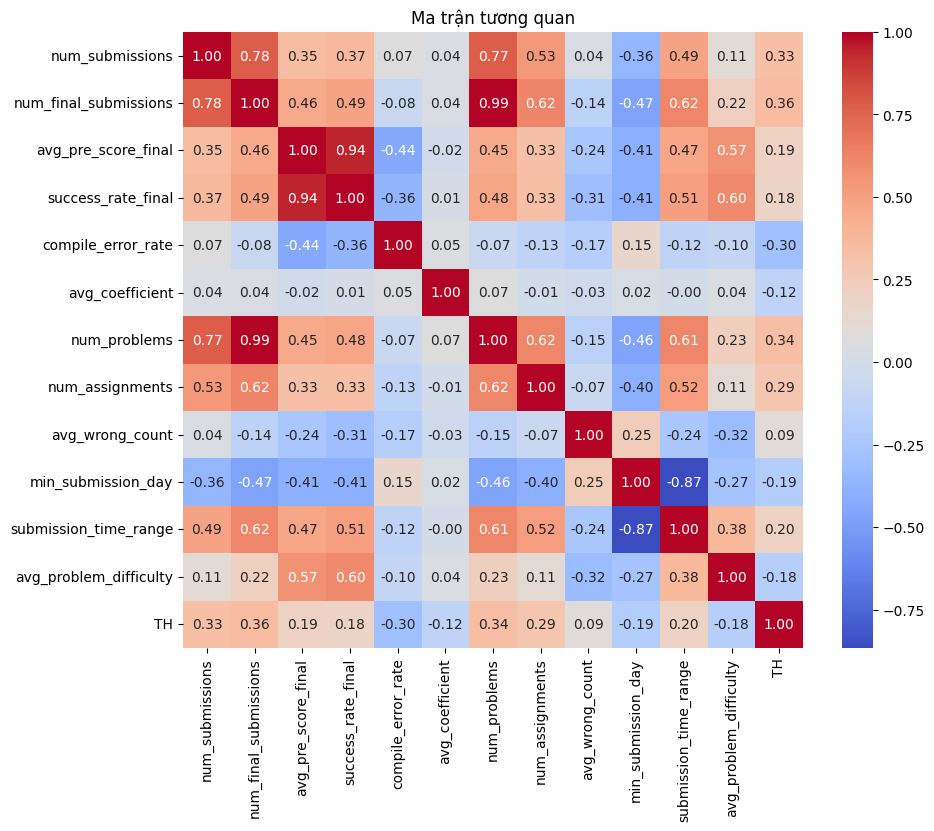

TH                        1.000000
num_final_submissions     0.358261
num_problems              0.340706
num_submissions           0.331316
num_assignments           0.287877
submission_time_range     0.203919
avg_pre_score_final       0.192904
success_rate_final        0.182758
avg_wrong_count           0.092408
avg_coefficient          -0.124541
avg_problem_difficulty   -0.176771
min_submission_day       -0.194253
compile_error_rate       -0.297053
Name: TH, dtype: float64


In [ ]:
correlation_matrix = train_data.drop(["concat('it001', username)", 'hash'], axis=1).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Ma trận tương quan')
plt.show()
print(correlation_matrix['TH'].sort_values(ascending=False))

**Kết quả**:
* R2 score khi train: 0.32
* R2 score trên hệ thống wecode tăng từ 24 lên 28

==> Hướng đi có phần hợp lý (nhất là phần tập trung vào bài nộp được tính điểm thôi)

### **Version 4** -- Submit ID: 271600

Một số điểm thay đổi trong version này:
* Nhận thấy điểm thực hành ở UIT trên hệ thống sẽ có điểm theo dạng làm tròn là x.0 hay 0.5 ==> tạo thêm hàm làm tròn điểm dự đoán được

* Thử một số feature mới như:
  * số lần nộp lại mỗi bài (avg_retries_per_problem) vì nhận thấy nếu sinh viên nộp lại nhiều lần cho 1 bài nghĩa là sinh viên đó gặp khó khăn -> điểm thực hành có thể thấp
  * tỉ lệ hoàn thành bài tập (problem_completion_rate) để tính tỉ lệ bài tập có submit ID được tính điểm là pre_score = 10000
  * giả định thêm 1 đặc trưng về khoảng cách từ ngày nộp sớm nhất đến deadline (sinh viên chăm chỉ sẽ nộp những bài đầu tiên từ sớm cách deadline khá xa) -> sibmission_time_range
  * Thêm feature mới num_final_submissions * success_rate_final để phản ánh số bài nộp đúng.

In [ ]:
import pandas as pd
import json
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

def round_to_half(x):
    return np.round(x * 2) / 2

submissions = pd.read_csv('annonimized.csv')
scores = pd.read_csv('th-public.csv')

scores['TH'] = pd.to_numeric(scores['TH'], errors='coerce')
print(f"Số giá trị NaN trong TH sau khi làm sạch: {scores['TH'].isna().sum()}")
scores = scores.dropna(subset=['TH'])

submissions['month'] = submissions['created_at'].str.split('-').str[0].astype(int)
submissions['day'] = submissions['created_at'].str.split('-').str[1].str.split(' ').str[0].astype(int)
submissions['submission_day'] = submissions['month'] * 30 + submissions['day']

problem_success_rate = submissions[submissions['is_final'] == 1].groupby("concat('it001',`problem_id`)")['pre_score'].apply(lambda x: (x == 10000).mean()).to_dict()
submissions['problem_difficulty'] = submissions["concat('it001',`problem_id`)"].map(problem_success_rate)

def parse_judgement(judgement_str):
    try:
        judgement_str = judgement_str.replace('\xa0', '').replace('""', '"')
        judgement = json.loads(judgement_str)
        wrong_count = judgement.get('verdicts', {}).get('WRONG', 0)
        times = judgement.get('times', [])
        mems = judgement.get('mems', [])
        return (wrong_count,
                np.mean(times) if times and all(isinstance(t, (int, float)) for t in times) else 0,
                np.mean(mems) if mems and all(isinstance(m, (int, float)) for m in mems) else 0)
    except:
        return 0, 0, 0

submissions[['wrong_count', 'avg_time', 'avg_mem']] = submissions['judgement'].apply(parse_judgement).apply(pd.Series)

def extract_features(group):
    features = {}
    features['num_submissions'] = len(group)
    features['num_final_submissions'] = group['is_final'].sum()
    features['avg_pre_score_final'] = group[group['is_final'] == 1]['pre_score'].mean() if group['is_final'].sum() > 0 else 0
    features['success_rate_final'] = group[group['is_final'] == 1]['pre_score'].eq(10000).mean() if group['is_final'].sum() > 0 else 0
    features['compile_error_rate'] = (group['status'] == 'Compilation Error').mean()
    features['avg_coefficient'] = group['coefficient'].mean()
    features['num_problems'] = group["concat('it001',`problem_id`)"].nunique()
    features['num_assignments'] = group["concat('it001',`assignment_id`)"].nunique()
    features['avg_wrong_count'] = group['wrong_count'].mean()
    features['min_submission_day'] = group['submission_day'].min()
    features['submission_time_range'] = group['submission_day'].max() - group['submission_day'].min()
    features['avg_problem_difficulty'] = group['problem_difficulty'].mean()
    features['avg_retries_per_problem'] = len(group) / group["concat('it001',`problem_id`)"].nunique() if group["concat('it001',`problem_id`)"].nunique() > 0 else 0
    features['problem_completion_rate'] = group[group['is_final'] == 1]['pre_score'].eq(10000).sum() / group["concat('it001',`problem_id`)"].nunique() if group["concat('it001',`problem_id`)"].nunique() > 0 else 0
    features['final_success_interaction'] = features['num_final_submissions'] * features['success_rate_final']
    return pd.Series(features)

features_df = submissions.groupby("concat('it001', username)").apply(extract_features, include_groups=False).reset_index()
data = features_df.merge(scores, left_on="concat('it001', username)", right_on='hash', how='left')

train_data = data[data['TH'].notna()]
test_data = data[data['TH'].isna()]

X = train_data.drop(["concat('it001', username)", 'hash', 'TH'], axis=1)
y = train_data['TH']
X_predict = test_data.drop(["concat('it001', username)", 'hash', 'TH'], axis=1)

for col in X.columns:
    X[col] = pd.to_numeric(X[col], errors='coerce').fillna(0)
for col in X_predict.columns:
    X_predict[col] = pd.to_numeric(X_predict[col], errors='coerce').fillna(0)

X['num_final_submissions'] = X['num_final_submissions'].clip(upper=100)
X_predict['num_final_submissions'] = X_predict['num_final_submissions'].clip(upper=100)
X['compile_error_rate'] = X['compile_error_rate'].clip(upper=0.5)
X_predict['compile_error_rate'] = X_predict['compile_error_rate'].clip(upper=0.5)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, reg_alpha=0.1, reg_lambda=1.0)
model.fit(X_train, y_train)

y_pred = model.predict(X_val)
y_pred_rounded = round_to_half(y_pred)
print(f"R² Score (với điểm làm tròn): {r2_score(y_val, y_pred_rounded)}")

predictions = model.predict(X_predict)
predictions_rounded = round_to_half(predictions)

submission = pd.DataFrame({'hash': test_data["concat('it001', username)"], 'TH': predictions_rounded})
all_usernames = pd.DataFrame({'hash': submissions["concat('it001', username)"].unique()})
submission = all_usernames.merge(submission, on='hash', how='left').fillna(0)
submission['TH'] = round_to_half(submission['TH'])
submission.to_csv('submission.csv', index=False)

Số giá trị NaN trong TH sau khi làm sạch: 8
R² Score (với điểm làm tròn): 0.2781970640838439


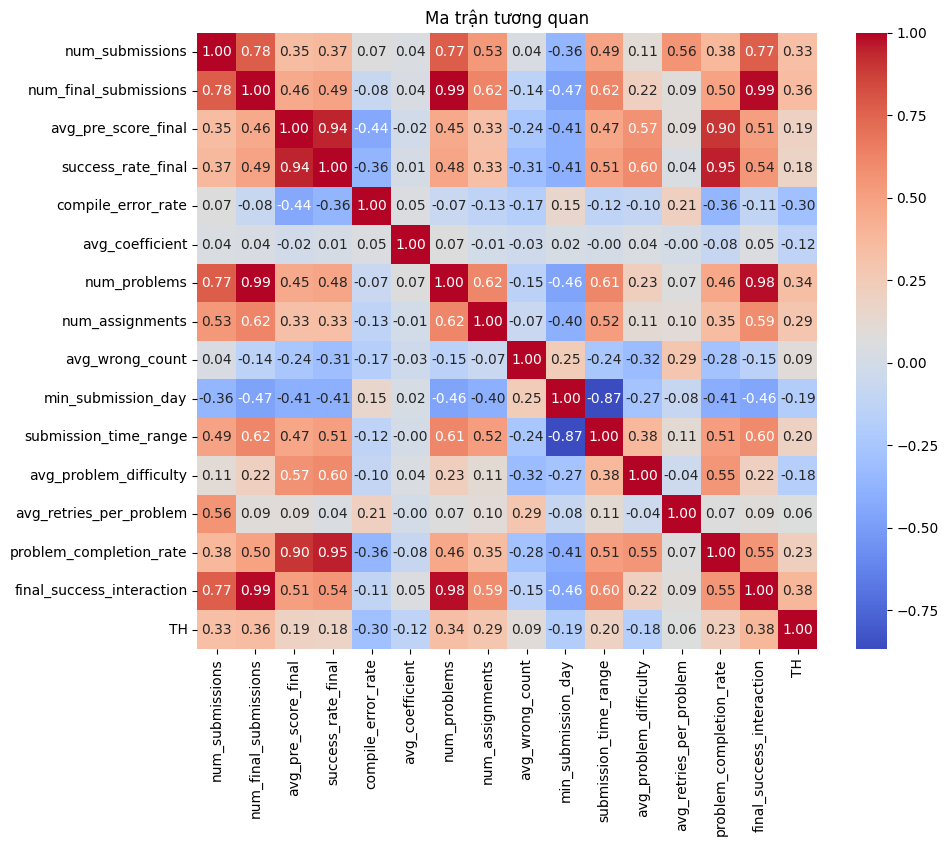

TH                           1.000000
final_success_interaction    0.383047
num_final_submissions        0.358261
num_problems                 0.340706
num_submissions              0.331316
num_assignments              0.287877
problem_completion_rate      0.225359
submission_time_range        0.203919
avg_pre_score_final          0.192904
success_rate_final           0.182758
avg_wrong_count              0.092408
avg_retries_per_problem      0.064404
avg_coefficient             -0.124541
avg_problem_difficulty      -0.176771
min_submission_day          -0.194253
compile_error_rate          -0.297053
Name: TH, dtype: float64


In [ ]:
correlation_matrix = train_data.drop(["concat('it001', username)", 'hash'], axis=1).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Ma trận tương quan')
plt.show()
print(correlation_matrix['TH'].sort_values(ascending=False))

**Kết quả**
* Điểm r2 score lúc train (với việc làm tròn) hạ nhẹ còn 0.28
* Tuy nhiêm điểm r2 score trên wecode tăng lên thành 31


==== **Nhận xét** ====

* Đặc trưng tương tác giữa num_final_submissions và success_rate_final là đặc trưng mạnh nhất, cho thấy số lượng bài nộp cuối đúng rất quan trọng.
* Đặc trưng avg_retries_per_problem (0.064) tương quan thấp ==> cần điều chỉnh.

### **Version 5** -- Submit ID: 271602

Một số cải tiến của version này:
* Thay vì chỉ tính tỷ lệ bài tập hoàn thành, ta thử tính trọng số dựa trên độ khó
* Tinh chỉnh avg_retries_per_problem bằng cách chỉ tính số lần nộp lại cho các bài chưa thành coogn (pre_score <10000) -> retries_for_failed
* thêm 1 vài đặc trưng tương tác dựa trên các đặc trưng có tương quan mạnh với TH trên heatmap trước

In [ ]:
import pandas as pd
import json
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

def round_to_half(x):
    return np.round(x * 2) / 2

submissions = pd.read_csv('annonimized.csv')
scores = pd.read_csv('th-public.csv')

scores['TH'] = pd.to_numeric(scores['TH'], errors='coerce')
print(f"Số giá trị NaN trong TH sau khi làm sạch: {scores['TH'].isna().sum()}")
scores = scores.dropna(subset=['TH'])

submissions['month'] = submissions['created_at'].str.split('-').str[0].astype(int)
submissions['day'] = submissions['created_at'].str.split('-').str[1].str.split(' ').str[0].astype(int)
submissions['submission_day'] = submissions['month'] * 30 + submissions['day']

problem_success_rate = submissions[submissions['is_final'] == 1].groupby("concat('it001',`problem_id`)")['pre_score'].apply(lambda x: (x == 10000).mean()).to_dict()
submissions['problem_difficulty'] = submissions["concat('it001',`problem_id`)"].map(problem_success_rate)

def parse_judgement(judgement_str):
    try:
        judgement_str = judgement_str.replace('\xa0', '').replace('""', '"')
        judgement = json.loads(judgement_str)
        wrong_count = judgement.get('verdicts', {}).get('WRONG', 0)
        times = judgement.get('times', [])
        mems = judgement.get('mems', [])
        return (wrong_count,
                np.mean(times) if times and all(isinstance(t, (int, float)) for t in times) else 0,
                np.mean(mems) if mems and all(isinstance(m, (int, float)) for m in mems) else 0)
    except:
        return 0, 0, 0

submissions[['wrong_count', 'avg_time', 'avg_mem']] = submissions['judgement'].apply(parse_judgement).apply(pd.Series)

def extract_features(group):
    features = {}
    features['num_submissions'] = len(group)
    features['num_final_submissions'] = group['is_final'].sum()
    features['avg_pre_score_final'] = group[group['is_final'] == 1]['pre_score'].mean() if group['is_final'].sum() > 0 else 0
    features['success_rate_final'] = group[group['is_final'] == 1]['pre_score'].eq(10000).mean() if group['is_final'].sum() > 0 else 0
    features['compile_error_rate'] = (group['status'] == 'Compilation Error').mean()
    features['avg_coefficient'] = group['coefficient'].mean()
    features['num_problems'] = group["concat('it001',`problem_id`)"].nunique()
    features['num_assignments'] = group["concat('it001',`assignment_id`)"].nunique()
    features['min_submission_day'] = group['submission_day'].min()
    features['submission_time_range'] = group['submission_day'].max() - group['submission_day'].min()
    features['avg_problem_difficulty'] = group['problem_difficulty'].mean()
    features['retries_for_failed'] = len(group[(group['is_final'] == 1) & (group['pre_score'] < 10000)]) / group["concat('it001',`problem_id`)"].nunique() if group["concat('it001',`problem_id`)"].nunique() > 0 else 0
    features['problem_completion_rate'] = group[group['is_final'] == 1]['pre_score'].eq(10000).sum() / group["concat('it001',`problem_id`)"].nunique() if group["concat('it001',`problem_id`)"].nunique() > 0 else 0
    features['weighted_completion_rate'] = group[group['is_final'] == 1].apply(
        lambda x: x['pre_score'] == 10000 and 1 / x['problem_difficulty'] if x['pre_score'] == 10000 and x['problem_difficulty'] > 0 else 0, axis=1
    ).sum() / group["concat('it001',`problem_id`)"].nunique() if group["concat('it001',`problem_id`)"].nunique() > 0 else 0
    features['days_to_deadline'] = 360 - group['submission_day'].min()
    features['final_success_interaction'] = features['num_final_submissions'] * features['success_rate_final']
    features['problems_success_interaction'] = features['num_problems'] * features['success_rate_final']
    features['completion_difficulty_interaction'] = features['problem_completion_rate'] * features['avg_problem_difficulty']
    return pd.Series(features)

features_df = submissions.groupby("concat('it001', username)").apply(extract_features, include_groups=False).reset_index()

data = features_df.merge(scores, left_on="concat('it001', username)", right_on='hash', how='left')

train_data = data[data['TH'].notna()]
test_data = data[data['TH'].isna()]

X = train_data.drop(["concat('it001', username)", 'hash', 'TH'], axis=1)
y = train_data['TH']
X_predict = test_data.drop(["concat('it001', username)", 'hash', 'TH'], axis=1)

for col in X.columns:
    X[col] = pd.to_numeric(X[col], errors='coerce').fillna(0)
for col in X_predict.columns:
    X_predict[col] = pd.to_numeric(X_predict[col], errors='coerce').fillna(0)

X['num_final_submissions'] = X['num_final_submissions'].clip(upper=100)
X_predict['num_final_submissions'] = X_predict['num_final_submissions'].clip(upper=100)
X['compile_error_rate'] = X['compile_error_rate'].clip(upper=0.5)
X_predict['compile_error_rate'] = X_predict['compile_error_rate'].clip(upper=0.5)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_predict_scaled = scaler.transform(X_predict)

X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, reg_alpha=0.1, reg_lambda=1.0)
model.fit(X_train, y_train)

y_pred = model.predict(X_val)
y_pred_rounded = round_to_half(y_pred)
print(f"R² Score (với điểm làm tròn): {r2_score(y_val, y_pred_rounded)}")
print(f"R² Score (không làm tròn): {r2_score(y_val, y_pred)}")

predictions = model.predict(X_predict_scaled)
predictions_rounded = round_to_half(predictions)

submission = pd.DataFrame({'hash': test_data["concat('it001', username)"], 'TH': predictions_rounded})
all_usernames = pd.DataFrame({'hash': submissions["concat('it001', username)"].unique()})
submission = all_usernames.merge(submission, on='hash', how='left').fillna(0)
submission['TH'] = round_to_half(submission['TH'])
submission.to_csv('submission.csv', index=False)

Số giá trị NaN trong TH sau khi làm sạch: 8
R² Score (với điểm làm tròn): 0.29026516558809046
R² Score (không làm tròn): 0.30032348536833686


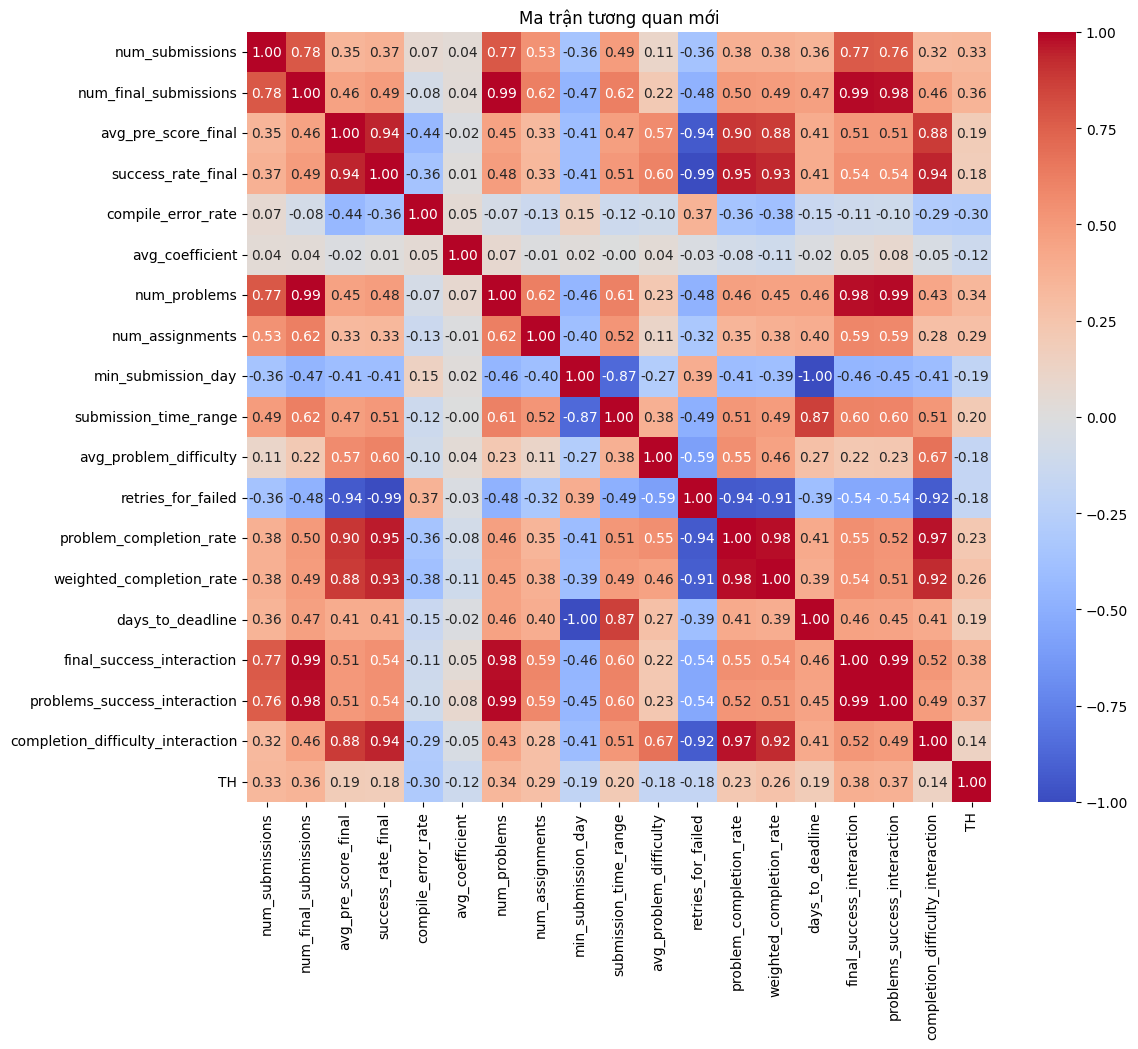

TH                                   1.000000
final_success_interaction            0.383047
problems_success_interaction         0.367436
num_final_submissions                0.358261
num_problems                         0.340706
num_submissions                      0.331316
num_assignments                      0.287877
weighted_completion_rate             0.262582
problem_completion_rate              0.225359
submission_time_range                0.203919
days_to_deadline                     0.194253
avg_pre_score_final                  0.192904
success_rate_final                   0.182758
completion_difficulty_interaction    0.138656
avg_coefficient                     -0.124541
retries_for_failed                  -0.175561
avg_problem_difficulty              -0.176771
min_submission_day                  -0.194253
compile_error_rate                  -0.297053
Name: TH, dtype: float64


In [ ]:
correlation_matrix = train_data.drop(["concat('it001', username)", 'hash'], axis=1).corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Ma trận tương quan mới')
plt.show()
print(correlation_matrix['TH'].sort_values(ascending=False))

**Kết quả**
* R2 score khi train: 0.29 (tăng nhẹ so với versino trước)
* tuy nhiên R2 trên wecode hạ nhẹ xuống còn 28

**Nhận xét**
* retries_for_failed (-0.176), completion_difficulty_interaction (0.139), và avg_coefficient (-0.125) có tương quan khá thấp --> loại bỏ ở version sau

**Bổ sung**: submit ID 2716103 thử sử dụng điểm lúc chưa làm tròn, kết quả trên wecode cho điểm giống với điểm đã làm tròn

### **verion 6** -- submit ID: 271613

Một số cải tiến ở version này:
* Thêm đặc trưng submission_frequency (số bài nộp trên đơn vị thời gian)
* Loại bỏ các đặc trưng yếu như nhận xét ở version 5
* Phân loại bài tập theo độ khó (dễ, trung bình, khó) dựa trên problem_difficulty và tính tỷ lệ hoàn thành cho từng nhóm

In [ ]:
import pandas as pd
import json
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

def round_to_half(x):
    return np.round(x * 2) / 2

submissions = pd.read_csv('annonimized.csv')
scores = pd.read_csv('th-public.csv')

scores['TH'] = pd.to_numeric(scores['TH'], errors='coerce')
print(f"Số giá trị NaN trong TH sau khi làm sạch: {scores['TH'].isna().sum()}")
scores = scores.dropna(subset=['TH'])

submissions['month'] = submissions['created_at'].str.split('-').str[0].astype(int)
submissions['day'] = submissions['created_at'].str.split('-').str[1].str.split(' ').str[0].astype(int)
submissions['submission_day'] = submissions['month'] * 30 + submissions['day']

problem_success_rate = submissions[submissions['is_final'] == 1].groupby("concat('it001',`problem_id`)")['pre_score'].apply(lambda x: (x == 10000).mean()).to_dict()
submissions['problem_difficulty'] = submissions["concat('it001',`problem_id`)"].map(problem_success_rate)

# thêm phân loại độ khó
problem_difficulty_bins = pd.qcut(submissions['problem_difficulty'], q=3, labels=['easy', 'medium', 'hard'], duplicates='drop')
submissions['problem_difficulty_category'] = problem_difficulty_bins

def parse_judgement(judgement_str):
    try:
        judgement_str = judgement_str.replace('\xa0', '').replace('""', '"')
        judgement = json.loads(judgement_str)
        wrong_count = judgement.get('verdicts', {}).get('WRONG', 0)
        times = judgement.get('times', [])
        mems = judgement.get('mems', [])
        return (wrong_count,
                np.mean(times) if times and all(isinstance(t, (int, float)) for t in times) else 0,
                np.mean(mems) if mems and all(isinstance(m, (int, float)) for m in mems) else 0)
    except:
        return 0, 0, 0

submissions[['wrong_count', 'avg_time', 'avg_mem']] = submissions['judgement'].apply(parse_judgement).apply(pd.Series)

def extract_features(group):
    features = {}
    features['num_submissions'] = len(group)
    features['num_final_submissions'] = group['is_final'].sum()
    features['success_rate_final'] = group[group['is_final'] == 1]['pre_score'].eq(10000).mean() if group['is_final'].sum() > 0 else 0
    features['compile_error_rate'] = (group['status'] == 'Compilation Error').mean()
    features['num_problems'] = group["concat('it001',`problem_id`)"].nunique()
    features['num_assignments'] = group["concat('it001',`assignment_id`)"].nunique()
    features['min_submission_day'] = group['submission_day'].min()
    features['submission_time_range'] = group['submission_day'].max() - group['submission_day'].min()
    features['avg_problem_difficulty'] = group['problem_difficulty'].mean()
    features['problem_completion_rate'] = group[group['is_final'] == 1]['pre_score'].eq(10000).sum() / group["concat('it001',`problem_id`)"].nunique() if group["concat('it001',`problem_id`)"].nunique() > 0 else 0
    features['weighted_completion_rate'] = group[group['is_final'] == 1].apply(
        lambda x: x['pre_score'] == 10000 and np.log1p(1 / x['problem_difficulty']) if x['pre_score'] == 10000 and x['problem_difficulty'] > 0 else 0, axis=1
    ).sum() / group["concat('it001',`problem_id`)"].nunique() if group["concat('it001',`problem_id`)"].nunique() > 0 else 0
    features['days_to_deadline'] = 360 - group['submission_day'].min()
    features['submission_frequency'] = len(group) / (group['submission_day'].max() - group['submission_day'].min() + 1) if group['submission_day'].nunique() > 1 else len(group)
    features['final_success_interaction'] = features['num_final_submissions'] * features['success_rate_final']
    features['problems_success_interaction'] = features['num_problems'] * features['success_rate_final']
    features['easy_completion_rate'] = group[(group['is_final'] == 1) & (group['problem_difficulty_category'] == 'easy')]['pre_score'].eq(10000).mean() if len(group[(group['is_final'] == 1) & (group['problem_difficulty_category'] == 'easy')]) > 0 else 0
    features['medium_completion_rate'] = group[(group['is_final'] == 1) & (group['problem_difficulty_category'] == 'medium')]['pre_score'].eq(10000).mean() if len(group[(group['is_final'] == 1) & (group['problem_difficulty_category'] == 'medium')]) > 0 else 0
    features['hard_completion_rate'] = group[(group['is_final'] == 1) & (group['problem_difficulty_category'] == 'hard')]['pre_score'].eq(10000).mean() if len(group[(group['is_final'] == 1) & (group['problem_difficulty_category'] == 'hard')]) > 0 else 0
    return pd.Series(features)

features_df = submissions.groupby("concat('it001', username)").apply(extract_features, include_groups=False).reset_index()

data = features_df.merge(scores, left_on="concat('it001', username)", right_on='hash', how='left')

train_data = data[data['TH'].notna()]
test_data = data[data['TH'].isna()]

X = train_data.drop(["concat('it001', username)", 'hash', 'TH'], axis=1)
y = train_data['TH']
X_predict = test_data.drop(["concat('it001', username)", 'hash', 'TH'], axis=1)

for col in X.columns:
    X[col] = pd.to_numeric(X[col], errors='coerce').fillna(0)
for col in X_predict.columns:
    X_predict[col] = pd.to_numeric(X_predict[col], errors='coerce').fillna(0)

X['num_final_submissions'] = X['num_final_submissions'].clip(upper=100)
X_predict['num_final_submissions'] = X_predict['num_final_submissions'].clip(upper=100)
X['compile_error_rate'] = X['compile_error_rate'].clip(upper=0.5)
X_predict['compile_error_rate'] = X_predict['compile_error_rate'].clip(upper=0.5)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_predict_scaled = scaler.transform(X_predict)

X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

y_train_rounded = round_to_half(y_train)
y_val_rounded = round_to_half(y_val)
model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, reg_alpha=1.0, reg_lambda=2.0, n_estimators=200, max_depth=4, learning_rate=0.05)
model.fit(X_train, y_train_rounded)

y_pred = model.predict(X_val)
y_pred_rounded = round_to_half(y_pred)
print(f"R² Score (huấn luyện với điểm làm tròn): {r2_score(y_val_rounded, y_pred_rounded)}")
print(f"R² Score (không làm tròn): {r2_score(y_val, y_pred)}")

predictions = model.predict(X_predict_scaled)
predictions_rounded = round_to_half(predictions)

submission = pd.DataFrame({'hash': test_data["concat('it001', username)"], 'TH': predictions_rounded})
all_usernames = pd.DataFrame({'hash': submissions["concat('it001', username)"].unique()})
submission = all_usernames.merge(submission, on='hash', how='left').fillna(0)
submission['TH'] = round_to_half(submission['TH'])
submission.to_csv('submission.csv', index=False)

Số giá trị NaN trong TH sau khi làm sạch: 8
R² Score (huấn luyện với điểm làm tròn): 0.303964091619938
R² Score (không làm tròn): 0.3120025944099849


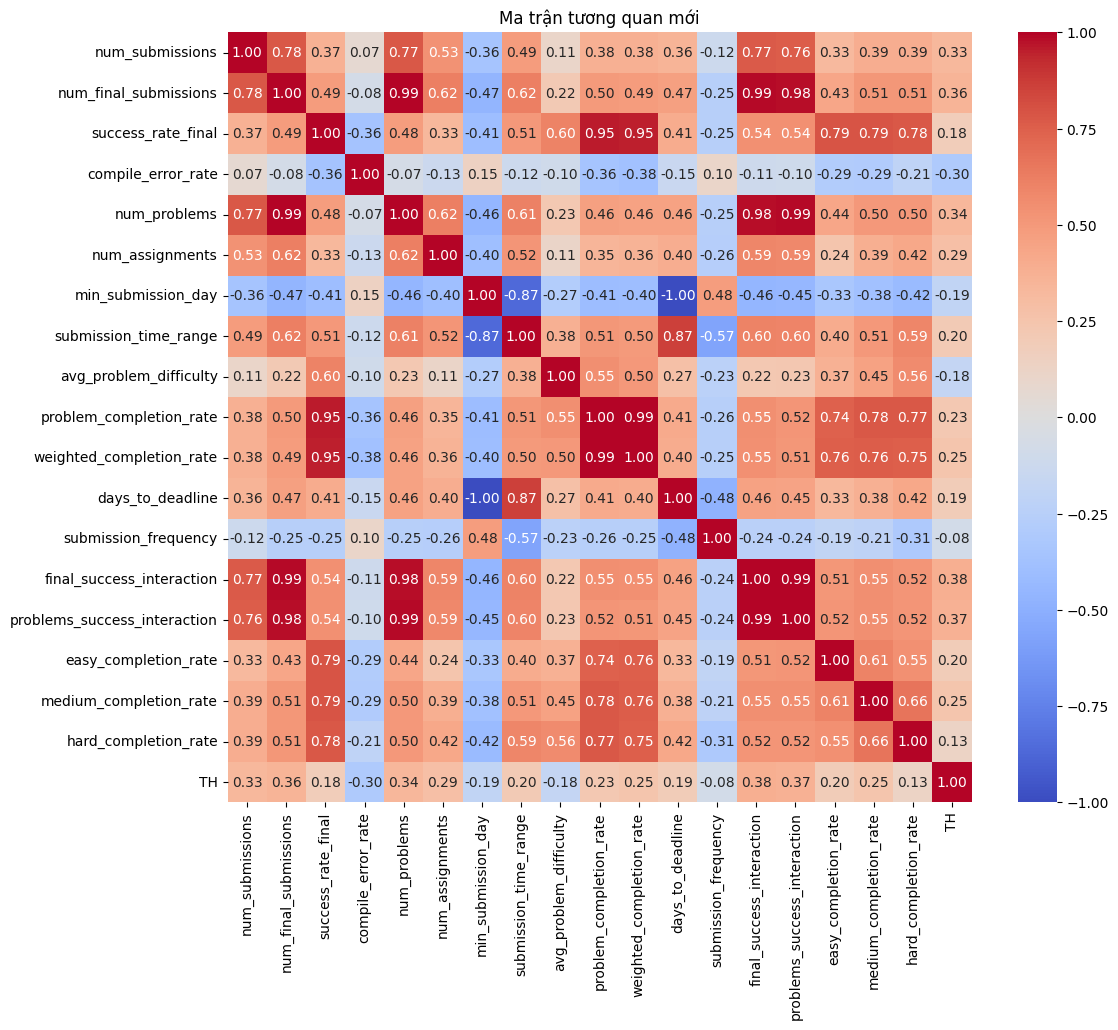

TH                              1.000000
final_success_interaction       0.383047
problems_success_interaction    0.367436
num_final_submissions           0.358261
num_problems                    0.340706
num_submissions                 0.331316
num_assignments                 0.287877
weighted_completion_rate        0.247973
medium_completion_rate          0.245964
problem_completion_rate         0.225359
submission_time_range           0.203919
easy_completion_rate            0.195241
days_to_deadline                0.194253
success_rate_final              0.182758
hard_completion_rate            0.132408
submission_frequency           -0.081760
avg_problem_difficulty         -0.176771
min_submission_day             -0.194253
compile_error_rate             -0.297053
Name: TH, dtype: float64


In [ ]:
correlation_matrix = train_data.drop(["concat('it001', username)", 'hash'], axis=1).corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Ma trận tương quan mới')
plt.show()
print(correlation_matrix['TH'].sort_values(ascending=False))

**Kết quả**
* R2 lúc train là 0.30
* R2 trên wecode tăng lên thành 36
**Nhận xét**
* Một số đặc trưng vừa thêm có tương quan thấp gây nhiễu như submission_frequency

### **version 7** - submit ID: 271615

Một số điểm cải tiến trong version này:
* thêm đặc trưng assigment_id và tính tỉ lệ hoàn thành bài tập theo assignment cũng như độ khó của nó tương tự như problem
* loại bỏ một số đặc trưng yếu như đã nhật xtes ở trên (hard_completion_rate và submission_frequency)
* Thêm đặc trưng về số lần nộp trước khi đạt điểm pre_score = 10000
* Thử catboot

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import json
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostRegressor

def round_to_half(x):
    return np.round(x * 2) / 2

submissions = pd.read_csv('annonimized.csv')
scores = pd.read_csv('th-public.csv')

scores['TH'] = pd.to_numeric(scores['TH'], errors='coerce')
print(f"Số giá trị NaN trong TH sau khi làm sạch: {scores['TH'].isna().sum()}")
scores = scores.dropna(subset=['TH'])

submissions['month'] = submissions['created_at'].str.split('-').str[0].astype(int)
submissions['day'] = submissions['created_at'].str.split('-').str[1].str.split(' ').str[0].astype(int)
submissions['submission_day'] = submissions['month'] * 30 + submissions['day']

# Thêm độ khó bài tập và assignment
problem_success_rate = submissions[submissions['is_final'] == 1].groupby("concat('it001',`problem_id`)")['pre_score'].apply(lambda x: (x == 10000).mean()).to_dict()
submissions['problem_difficulty'] = submissions["concat('it001',`problem_id`)"].map(problem_success_rate)
assignment_success_rate = submissions[submissions['is_final'] == 1].groupby("concat('it001',`assignment_id`)")['pre_score'].apply(lambda x: (x == 10000).mean()).to_dict()
submissions['assignment_difficulty'] = submissions["concat('it001',`assignment_id`)"].map(assignment_success_rate)

problem_difficulty_bins = pd.qcut(submissions['problem_difficulty'], q=3, labels=['easy', 'medium', 'hard'], duplicates='drop')
submissions['problem_difficulty_category'] = problem_difficulty_bins

def parse_judgement(judgement_str):
    try:
        judgement_str = judgement_str.replace('\xa0', '').replace('""', '"')
        judgement = json.loads(judgement_str)
        wrong_count = judgement.get('verdicts', {}).get('WRONG', 0)
        times = judgement.get('times', [])
        mems = judgement.get('mems', [])
        return (wrong_count,
                np.mean(times) if times and all(isinstance(t, (int, float)) for t in times) else 0,
                np.mean(mems) if mems and all(isinstance(m, (int, float)) for m in mems) else 0)
    except:
        return 0, 0, 0

submissions[['wrong_count', 'avg_time', 'avg_mem']] = submissions['judgement'].apply(parse_judgement).apply(pd.Series)

def extract_features(group):
   # tính số lần nộp trước khi đạt được điểm 10000
    def count_attempts(group):
        attempts = 0
        for problem_id in group["concat('it001',`problem_id`)"].unique():
            problem_submissions = group[group["concat('it001',`problem_id`)"] == problem_id]
            if (problem_submissions['pre_score'] == 10000).any():
                attempts += len(problem_submissions[problem_submissions['pre_score'] < 10000])
        return attempts / group["concat('it001',`problem_id`)"].nunique() if group["concat('it001',`problem_id`)"].nunique() > 0 else 0


    features = {}
    features['num_submissions'] = len(group)
    features['num_final_submissions'] = group['is_final'].sum()
    features['compile_error_rate'] = (group['status'] == 'Compilation Error').mean()
    features['num_problems'] = group["concat('it001',`problem_id`)"].nunique()
    features['num_assignments'] = group["concat('it001',`assignment_id`)"].nunique()
    features['min_submission_day'] = group['submission_day'].min()
    features['submission_time_range'] = group['submission_day'].max() - group['submission_day'].min()
    features['problem_completion_rate'] = group[group['is_final'] == 1]['pre_score'].eq(10000).sum() / group["concat('it001',`problem_id`)"].nunique() if group["concat('it001',`problem_id`)"].nunique() > 0 else 0
    features['weighted_completion_rate'] = group[group['is_final'] == 1].apply(
        lambda x: x['pre_score'] == 10000 and 1 / (x['problem_difficulty'] ** 2) if x['pre_score'] == 10000 and x['problem_difficulty'] > 0 else 0, axis=1
    ).sum() / group["concat('it001',`problem_id`)"].nunique() if group["concat('it001',`problem_id`)"].nunique() > 0 else 0
    features['days_to_deadline'] = 360 - group['submission_day'].min()
    features['final_success_interaction'] = features['num_final_submissions'] * (group[group['is_final'] == 1]['pre_score'].eq(10000).mean() if group['is_final'].sum() > 0 else 0)
    features['problems_success_interaction'] = features['num_problems'] * (group[group['is_final'] == 1]['pre_score'].eq(10000).mean() if group['is_final'].sum() > 0 else 0)
    features['easy_completion_rate'] = group[(group['is_final'] == 1) & (group['problem_difficulty_category'] == 'easy')]['pre_score'].eq(10000).mean() if len(group[(group['is_final'] == 1) & (group['problem_difficulty_category'] == 'easy')]) > 0 else 0
    features['medium_completion_rate'] = group[(group['is_final'] == 1) & (group['problem_difficulty_category'] == 'medium')]['pre_score'].eq(10000).mean() if len(group[(group['is_final'] == 1) & (group['problem_difficulty_category'] == 'medium')]) > 0 else 0
    features['assignment_completion_rate'] = group[group['is_final'] == 1]['pre_score'].eq(10000).sum() / group["concat('it001',`assignment_id`)"].nunique() if group["concat('it001',`assignment_id`)"].nunique() > 0 else 0
    features['avg_assignment_difficulty'] = group['assignment_difficulty'].mean()
    features['avg_attempts_before_success'] = count_attempts(group)
    return pd.Series(features)


features_df = submissions.groupby("concat('it001', username)").apply(extract_features, include_groups=False).reset_index()

data = features_df.merge(scores, left_on="concat('it001', username)", right_on='hash', how='left')

train_data = data[data['TH'].notna()]
test_data = data[data['TH'].isna()]

X = train_data.drop(["concat('it001', username)", 'hash', 'TH'], axis=1)
y = train_data['TH']
X_predict = test_data.drop(["concat('it001', username)", 'hash', 'TH'], axis=1)

for col in X.columns:
    X[col] = pd.to_numeric(X[col], errors='coerce').fillna(0)
for col in X_predict.columns:
    X_predict[col] = pd.to_numeric(X_predict[col], errors='coerce').fillna(0)


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_predict_scaled = scaler.transform(X_predict)


X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

y_train_rounded = np.clip(round_to_half(y_train), 0, 10)
y_val_rounded = np.clip(round_to_half(y_val), 0, 10)
model = CatBoostRegressor(iterations=300, depth=4, learning_rate=0.03, l2_leaf_reg=3.0, random_seed=42, verbose=0)
model.fit(X_train, y_train_rounded)

y_pred = model.predict(X_val)
y_pred_rounded = round_to_half(y_pred)
print(f"R² Score (huấn luyện với điểm làm tròn): {r2_score(y_val_rounded, y_pred_rounded)}")
print(f"R² Score (CatBoost, không làm tròn): {r2_score(y_val, y_pred)}")
print(f"Phân phối điểm làm tròn trên tập validation: {np.unique(y_val_rounded, return_counts=True)}")

predictions = model.predict(X_predict_scaled)
predictions_rounded = np.clip(round_to_half(predictions), 0, 10)

submission = pd.DataFrame({'hash': test_data["concat('it001', username)"], 'TH': predictions_rounded})
all_usernames = pd.DataFrame({'hash': submissions["concat('it001', username)"].unique()})
submission = all_usernames.merge(submission, on='hash', how='left').fillna(0)
submission['TH'] = np.clip(round_to_half(submission['TH']), 0, 10)
submission.to_csv('submission.csv', index=False)

Số giá trị NaN trong TH sau khi làm sạch: 8
R² Score (huấn luyện với điểm làm tròn): 0.3978995844097496
R² Score (CatBoost, không làm tròn): 0.40092243745731626
Phân phối điểm làm tròn trên tập validation: (array([ 1. ,  1.5,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,  5.5,  6. ,  6.5,
        7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. ]), array([ 1,  2,  2,  3,  7,  3,  6,  7,  5,  9, 10,  4,  7, 14, 13, 22, 20,
       16]))


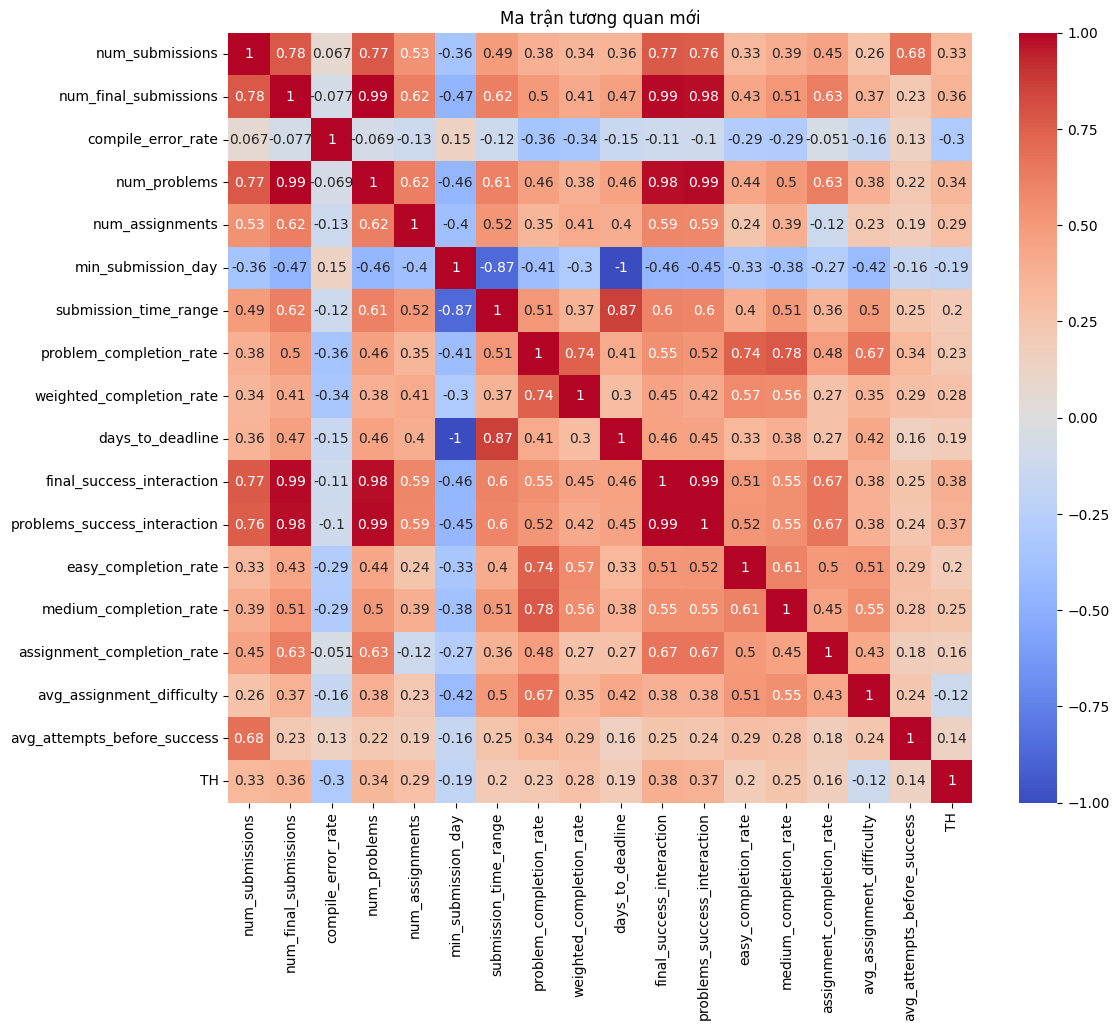

TH                              1.000000
final_success_interaction       0.383047
problems_success_interaction    0.367436
num_final_submissions           0.358261
num_problems                    0.340706
num_submissions                 0.331316
num_assignments                 0.287877
weighted_completion_rate        0.276879
medium_completion_rate          0.245964
problem_completion_rate         0.225359
submission_time_range           0.203919
easy_completion_rate            0.195241
days_to_deadline                0.194253
assignment_completion_rate      0.164343
avg_attempts_before_success     0.137827
avg_assignment_difficulty      -0.120480
min_submission_day             -0.194253
compile_error_rate             -0.297053
Name: TH, dtype: float64


In [ ]:
correlation_matrix = train_data.drop(["concat('it001', username)", 'hash'], axis=1).corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Ma trận tương quan mới')
plt.show()
print(correlation_matrix['TH'].sort_values(ascending=False))

**Kết quả**
* Điểm R2 khi train là 0.38
* Điểm R2 trên webcode: 39 (tốt nhất hiện tại)



**Đã tiến hành thử thêm một số feature mới tuy nhiên kết quả đạt được chưa bằng version 7 này**

### **Một số model khác với các feature trong version 7**

In [ ]:
xgb_model = xgb.XGBRegressor(n_estimators=300, max_depth=4, learning_rate=0.05, random_state=42)
xgb_model.fit(X_train, y_train_rounded)

xgb_pred = xgb_model.predict(X_val)
xgb_pred_rounded = round_to_half(xgb_pred)

print("XGBoost:")
print(f"R² Score (làm tròn): {r2_score(y_val_rounded, xgb_pred_rounded)}")
print(f"R² Score (không làm tròn): {r2_score(y_val, xgb_pred)}")


XGBoost:
R² Score (làm tròn): 0.4034443878035926
R² Score (không làm tròn): 0.39577638440244745


In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=200, max_depth=8, random_state=42)
rf_model.fit(X_train, y_train_rounded)

rf_pred = rf_model.predict(X_val)
rf_pred_rounded = round_to_half(rf_pred)

print("Random Forest:")
print(f"R² Score (làm tròn): {r2_score(y_val_rounded, rf_pred_rounded)}")
print(f"R² Score (không làm tròn): {r2_score(y_val, rf_pred)}")


Random Forest:
R² Score (làm tròn): 0.39692108969318907
R² Score (không làm tròn): 0.3901179836584727


In [ ]:
from sklearn.ensemble import ExtraTreesRegressor

et_model = ExtraTreesRegressor(n_estimators=200, max_depth=8, random_state=42)
et_model.fit(X_train, y_train_rounded)

et_pred = et_model.predict(X_val)
et_pred_rounded = round_to_half(et_pred)

print("Extra Trees:")
print(f"R² Score (làm tròn): {r2_score(y_val_rounded, et_pred_rounded)}")
print(f"R² Score (không làm tròn): {r2_score(y_val, et_pred)}")


Extra Trees:
R² Score (làm tròn): 0.3629999395190904
R² Score (không làm tròn): 0.37670078954123476


In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

gb_model = GradientBoostingRegressor(n_estimators=300, learning_rate=0.05, max_depth=4, random_state=42)
gb_model.fit(X_train, y_train_rounded)

gb_pred = gb_model.predict(X_val)
gb_pred_rounded = round_to_half(gb_pred)

print("Gradient Boosting:")
print(f"R² Score (làm tròn): {r2_score(y_val_rounded, gb_pred_rounded)}")
print(f"R² Score (không làm tròn): {r2_score(y_val, gb_pred)}")


Gradient Boosting:
R² Score (làm tròn): 0.38061284441718013
R² Score (không làm tròn): 0.3817772524813223


In [ ]:
ensemble_pred = (rf_pred + xgb_pred + et_pred + gb_pred + y_pred) / 5
ensemble_pred_rounded = round_to_half(ensemble_pred)
print("Ensemble trung bình nhiều model:")
print(f"R² Score (làm tròn): {r2_score(y_val_rounded, ensemble_pred_rounded)}")
print(f"R² Score (không làm tròn): {r2_score(y_val, ensemble_pred)}")


Ensemble trung bình nhiều model:
R² Score (làm tròn): 0.4080106964808752
R² Score (không làm tròn): 0.4077724690621952


In [ ]:
rf_predictions = rf_model.predict(X_predict_scaled)
rf_predictions_rounded = np.clip(round_to_half(rf_predictions), 0, 10)

submission_rf = pd.DataFrame({'hash': test_data["concat('it001', username)"], 'TH': rf_predictions_rounded})
submission_rf = all_usernames.merge(submission_rf, on='hash', how='left').fillna(0)
submission_rf['TH'] = np.clip(round_to_half(submission_rf['TH']), 0, 10)
submission_rf.to_csv('submission_rf.csv', index=False)


In [ ]:
xgb_predictions = xgb_model.predict(X_predict_scaled)
xgb_predictions_rounded = np.clip(round_to_half(xgb_predictions), 0, 10)

submission_xgb = pd.DataFrame({'hash': test_data["concat('it001', username)"], 'TH': xgb_predictions_rounded})
submission_xgb = all_usernames.merge(submission_xgb, on='hash', how='left').fillna(0)
submission_xgb['TH'] = np.clip(round_to_half(submission_xgb['TH']), 0, 10)
submission_xgb.to_csv('submission_xgb.csv', index=False)


In [ ]:
et_predictions = et_model.predict(X_predict_scaled)
et_predictions_rounded = np.clip(round_to_half(et_predictions), 0, 10)

submission_et = pd.DataFrame({'hash': test_data["concat('it001', username)"], 'TH': et_predictions_rounded})
submission_et = all_usernames.merge(submission_et, on='hash', how='left').fillna(0)
submission_et['TH'] = np.clip(round_to_half(submission_et['TH']), 0, 10)
submission_et.to_csv('submission_et.csv', index=False)


In [ ]:
gb_predictions = gb_model.predict(X_predict_scaled)
gb_predictions_rounded = np.clip(round_to_half(gb_predictions), 0, 10)

submission_gb = pd.DataFrame({'hash': test_data["concat('it001', username)"], 'TH': gb_predictions_rounded})
submission_gb = all_usernames.merge(submission_gb, on='hash', how='left').fillna(0)
submission_gb['TH'] = np.clip(round_to_half(submission_gb['TH']), 0, 10)
submission_gb.to_csv('submission_gb.csv', index=False)

In [ ]:
ensemble_predictions = (
    rf_predictions +
    xgb_predictions +
    et_predictions +
  #  gb_predictions +
    predictions  # từ CatBoost
) / 4

ensemble_predictions_rounded = np.clip(round_to_half(ensemble_predictions), 0, 10)

submission_ensemble = pd.DataFrame({'hash': test_data["concat('it001', username)"], 'TH': ensemble_predictions_rounded})
submission_ensemble = all_usernames.merge(submission_ensemble, on='hash', how='left').fillna(0)
submission_ensemble['TH'] = np.clip(round_to_half(submission_ensemble['TH']), 0, 10)
submission_ensemble.to_csv('submission_ensemble.csv', index=False)


**Kết quả trên wecode của các model này**
* Model random forest (ID: 273864) = 38
* Model XGBoost (ID: 273866) = 34
* Model Extra Tree (ID: 273867) = 27
* Model Gradient Boosting (ID: 273868) = 31
* Essemble model (bao gồm random forest,  XGBoost,  Extra Tree và model CatBoost) = 38  

==> Các model khác chưa cho kết quả tốt hơn catboost (chỉ bé hơn hoặc bằng)